<a href="https://colab.research.google.com/github/chasslayy/Jua-Shade/blob/main/JuaShade_SkinTone_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JuaShade – Skin Tone Classification (Google Colab Template)

This notebook is a starter template for **Chastity (Chasslayy)** to build a skin tone classifier
using 5 classes:

- `tan`
- `medium`
- `deep`
- `brown`
- `light`

It assumes the following folder structure in Colab:

```text
/content/
  data/
    raw/
      train/
        tan/
        medium/
        deep/
        brown/
        light/
```

Upload your images into the matching folders, then run the cells in order.


# New Section

In [ ]:
# 1. Imports & basic setup

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

print("TensorFlow version:", tf.__version__)

# Base directory for your dataset in Colab
TRAIN_DIR = "/content/data/raw/train"

# Your 5 skin tone classes
CLASSES = ['tan', 'medium', 'deep', 'brown', 'light']

print("✅ Using train directory:", TRAIN_DIR)
print("✅ Classes:", CLASSES)

In [ ]:
# 2. Count how many images per tone

def count_images_in_folder(folder):
    if not os.path.exists(folder):
        return 0
    return len([f for f in os.listdir(folder)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

print("📊 Training samples per class:\n")
class_counts = {}
for tone in CLASSES:
    tone_path = os.path.join(TRAIN_DIR, tone)
    n = count_images_in_folder(tone_path)
    class_counts[tone] = n
    if n == 0:
        print(f"  ⚠️ {tone}: 0 images (or folder missing: {tone_path})")
    else:
        print(f"  {tone}: {n} images")

# Save a small text summary
os.makedirs("reports", exist_ok=True)
summary_lines = ["Skin Tone Dataset Summary\n",
                 f"Train directory: {TRAIN_DIR}\n\n",
                 "Classes and counts:\n"]
for tone, n in class_counts.items():
    summary_lines.append(f"  {tone}: {n} images\n")

summary_text = "".join(summary_lines)
print("\n" + summary_text)

with open("reports/dataset_summary.txt", "w") as f:
    f.write(summary_text)

print("✅ Saved reports/dataset_summary.txt")

⚠️ No images in data/raw/train/tan


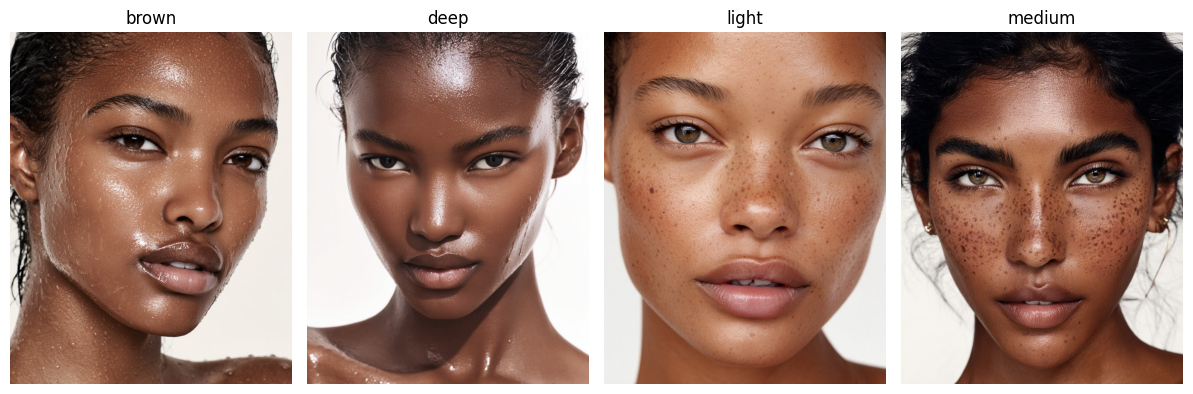

In [4]:
# 📸 Show one sample image from each class

import os
import cv2
import matplotlib.pyplot as plt

# --- Define dataset directory and classes ---
TRAIN_DIR = 'data/raw/train'
CLASSES = ['brown', 'deep', 'light', 'medium', 'tan']

# --- Helper function to read image ---
def read_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"⚠️ Could not read image at {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# --- Function to show one image per class ---
def show_sample_images_per_class(base_dir, classes, n_cols=5):
    plt.figure(figsize=(3 * n_cols, 4))

    for idx, tone in enumerate(classes):
        tone_path = os.path.join(base_dir, tone)
        if not os.path.exists(tone_path):
            print(f"⚠️ Skipping {tone}: folder not found at {tone_path}")
            continue

        # Find all image files in this folder
        files = [
            f for f in os.listdir(tone_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        if len(files) == 0:
            print(f"⚠️ No images in {tone_path}")
            continue

        # Load and display first image
        img_path = os.path.join(tone_path, files[0])
        img = read_image(img_path)

        plt.subplot(1, n_cols, idx + 1)
        plt.imshow(img)
        plt.title(tone)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- Run the function ---
show_sample_images_per_class(TRAIN_DIR, CLASSES)


In [ ]:
# 4. Build TensorFlow datasets from folders

IMG_SIZE = (224, 224)
BATCH_SIZE = 8
SEED = 1337

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    class_names=CLASSES,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='training'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    class_names=CLASSES,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='validation'
)

class_names = train_ds.class_names
print("Classes (from dataset):", class_names)

In [ ]:
# 5. Optimize dataset performance

AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(100, reshuffle_each_iteration=True)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [ ]:
# 6. Build a transfer learning model (MobileNetV2)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # fine-tune later if needed

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(CLASSES), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

In [ ]:
# 7. Train the model

EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

In [ ]:
# 8. Evaluate model and show sample predictions

loss, acc = model.evaluate(val_ds)
print(f"Validation loss: {loss:.4f}, accuracy: {acc:.4f}")

# Show a few sample predictions
class_names = CLASSES

plt.figure(figsize=(12, 6))
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1)

    for i in range(min(5, images.shape[0])):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i].numpy()]
        pred_label = class_names[pred_labels[i].numpy()]
        plt.title(f"T: {true_label}\nP: {pred_label}")
        plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
import os

base_path = "/content/data/raw/train"

# Verify folders exist
print("✅ Folders found:")
for folder in sorted(os.listdir(base_path)):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        print(f"- {folder}")


In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Base path for your training images
base_path = "/content/data/raw/train"

# Create a list of your tone folders
tone_folders = sorted(os.listdir(base_path))

plt.figure(figsize=(15, 6))
for i, tone in enumerate(tone_folders):
    folder_path = os.path.join(base_path, tone)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        if len(images) > 0:
            # Pick one random image from the folder
            img_path = os.path.join(folder_path, random.choice(images))
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(tone_folders), i + 1)
            plt.imshow(img)
            plt.title(tone, fontsize=12)
            plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# BASELINE MODEL (simple MobileNetV2)
import tensorflow as tf
from tensorflow.keras import layers, models

# Load base model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze for baseline

# Build model
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')  # 5 skin tone classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS = 5
history_baseline = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)



In [ ]:
base_model.trainable = True  # unfreeze backbone

# Optionally: only fine-tune last few layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS = 5
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['accuracy'], label='Train (Baseline)')
plt.plot(history_baseline.history['val_accuracy'], label='Val (Baseline)')
plt.plot(history_finetune.history['accuracy'], label='Train (Advanced)')
plt.plot(history_finetune.history['val_accuracy'], label='Val (Advanced)')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['loss'], label='Train (Baseline)')
plt.plot(history_baseline.history['val_loss'], label='Val (Baseline)')
plt.plot(history_finetune.history['loss'], label='Train (Adv_
